**Exercise 4: Image descriptors**

*CPSC 480/580: Computer Vision*

*Yale University*

*Instructor: Alex Wong*


**Prerequisites**:

1. Enable Google Colaboratory as an app on your Google Drive account

2. Create a new Google Colab notebook, this will also create a "Colab Notebooks" directory under "MyDrive" i.e.
```
/content/drive/MyDrive/Colab Notebooks
```

3. Create the following directory structure in your Google Drive
```
/content/drive/MyDrive/Colab Notebooks/CPSC 480-580: Computer Vision/Exercises
```

4. Move the 04_exercise.ipynb into
```
/content/drive/MyDrive/Colab Notebooks/CPSC 480-580: Computer Vision/Exercises
```
so that its absolute path is
```
/content/drive/MyDrive/Colab Notebooks/CPSC 480-580: Computer Vision/Exercises/04_exercise.ipynb
```

In this exercise, we will implement histogram of oriented gradients (HOG) and apply HOG and Scale Invariant Feature Transform (SIFT). We will also test SIFT for matching features across images.

**Submission**:

1. Implement all TODOs in the code blocks below.

2. Run the Colab Notebook to produce results for each code block.

3. List any collaborators.

```
Collaborators: Doe, Jane (Please write names in <Last Name, First Name> format)

Collaboration details: Discussed ... implementation details with Jane Doe.
```

Import packages

In [9]:
import skimage.feature
from skimage.feature import hog
import skimage.filters as filters
import skimage.transform
import numpy as np
import matplotlib.pyplot as plt

Utility functions for plotting

In [16]:
def config_plot(ax):
    '''
    Function to remove axis tickers and box around figure
    '''

    if isinstance(ax, (list, tuple, np.ndarray)):
        for a in ax:
            a.axis('off')
    else:
        ax.axis('off')

Loading data

In [3]:
# Load coffee image from skimage
image_coffee = skimage.data.coffee()

# Load astronaunt image from skimage
image_astronaunt = skimage.data.chelsea()

images = [image_coffee, image_astronaunt]
images_gray = [None] * len(images)

# Create gray (if images aren't already) images
for idx, image in enumerate(images):

    # Convert images to gray if it isn't already
    if len(image.shape) > 2 and image.shape[-1] > 1:
        image_gray = skimage.color.rgb2gray(image)
        pass
    else:
        image_gray = image

    images_gray[idx] = image_gray

feat: cropping function

In [7]:
def crop_shape(H, W, cell_size, magnitude, orientation):
  '''
  Function to make shapes divisible by cell_size. Avoids partial cells. Keeps
  gradients consistent with cropped region as well.
  '''
  Hc = (H // cell_size) * cell_size
  Wc = (W // cell_size) * cell_size
  magnitude   = magnitude[:Hc, :Wc]
  orientation = orientation[:Hc, :Wc]
  return Hc, Wc, magnitude, orientation

# ex: orient = 37 degrees
def find_neighbor_bins(orient, bins):
  """
  Vectorized: orient is a float ndarray (deg in [0,180)), bins are sorted bin *centers* (deg).
  Returns (idx_lower, idx_upper, lower_centers, upper_centers) as ndarrays, handling wrap 160↔0.
  """
  bins_arr = np.asarray(bins, dtype=float)
  N = bins_arr.size
  # handle orientations near 179 deg -> map to (0, 160)
  idx_upper = np.searchsorted(bins_arr, orient, side='right') % N
  idx_lower = (idx_upper - 1) % N
  lower = bins_arr[idx_lower]
  upper = bins_arr[idx_upper]
  return idx_lower, idx_upper, lower, upper

Computing gradients and orientation

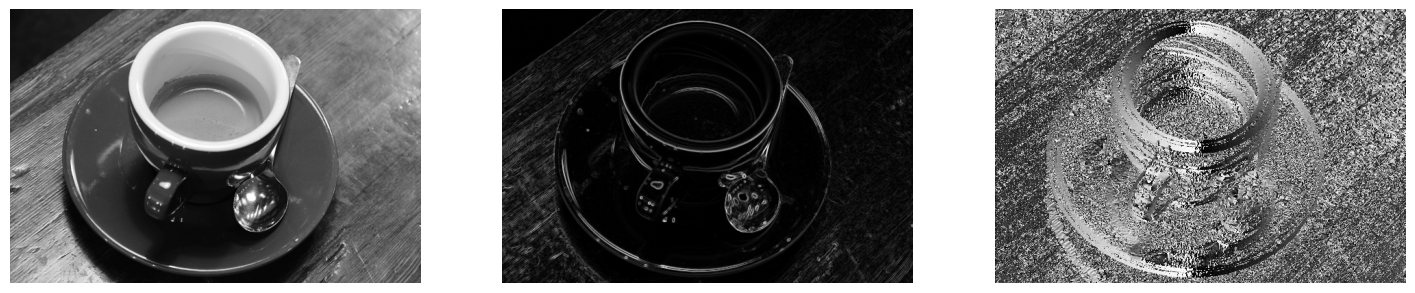

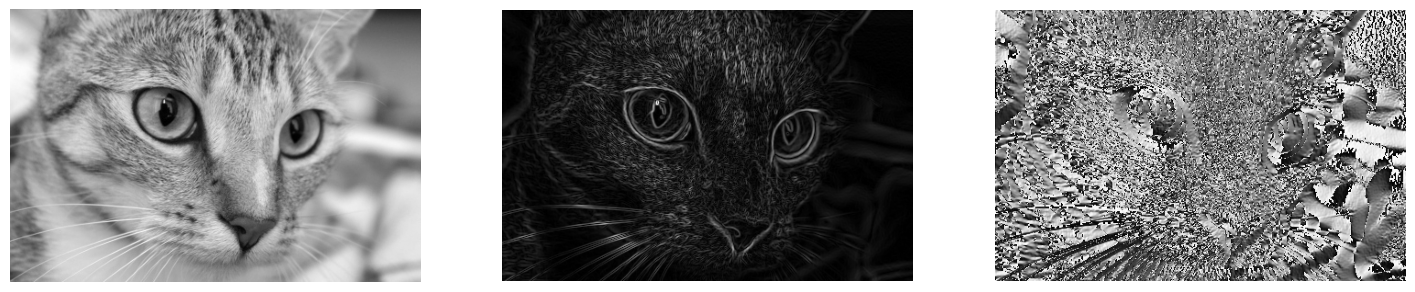

In [19]:
histogram_angles = [
    0, 20, 40, 60, 80, 100, 120, 140, 160
]
histogram_distance = 20

for image_gray in images_gray:

    # TODO: Run sobel filters to get gradients
    gradients_x = filters.sobel(image=image_gray,axis=0)
    gradients_y = filters.sobel(image=image_gray,axis=1)

    # TODO: Compute magnitude
    magnitude = np.sqrt(gradients_x ** 2 + gradients_y ** 2)

    # TODO: Obtain unsigned orientation
    angle = np.arctan2(gradients_y, gradients_x) # arctan2 proper quadrant map
    orientation = np.degrees(angle) % 180 # arctan2 returns radians

    # TODO: Define 8 x 8 histogram block (cell)
    # make divisible by cell_size with Hc and Wc:
    H, W = image_gray.shape
    cell_size, cell_stride = 8, 8
    Hc, Wc, magnitude, orientation = crop_shape(H, W, cell_size, magnitude, orientation)
    histogram_block = ( # generator expression -> computationally efficient
        (r, r + cell_size, c, c + cell_size)
        for r in range(0, Hc, cell_stride)
        for c in range(0, Wc, cell_stride)
    )
    # TODO: For each block
    '''
    Unwrapping turns the circular segment (like 160°→0°) into a straight segment (160°→180°) just for the math
    '''
    for r0, r1, c0, c1 in histogram_block:
       # TODO: Determine the histogram bin
       # compute weight of gradient magnitude by dist. bin i and i + 1
       pixel_mag = magnitude[r0:r1, c0:c1].astype(float)
       pixel_ori = orientation[r0:r1, c0:c1].astype(float)
       idx_lo, idx_hi, lo, hi = find_neighbor_bins(pixel_ori, histogram_angles)
       # unwrap 0/180 boundary so distances are measured along the shorter arc in [0,180)
       span = float(histogram_distance)
       # If hi < lo (e.g., hi = 0, lo = 160), lift hi by +180 for distance; lift θ likewise < lo
       hi_unwrapped = np.where(hi < lo, hi + 180.0, hi)
       theta_unwrapped = np.where((hi < lo) & (pixel_ori < lo), pixel_ori + 180.0, pixel_ori)
       weight = (theta_unwrapped - lo) / (hi_unwrapped - lo)           # a(u,v) in [0,1]

       ## add weighted magnitude to bins
       cell_hist = np.zeros(len(histogram_angles), dtype=float)
       mag = pixel_mag.ravel()
       w = weight.ravel() # q why arae we calling ravel on the original vars?
       # np.add.at(array, indices, values) --> vectorized and safe method
       np.add.at(cell_hist,idx_lo.ravel(), (1.0-w) * mag)
       np.add.at(cell_hist, idx_hi.ravel(), w * mag)

    # Create visualization
    fig = plt.figure(figsize=(18, 8))

    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(image_gray, cmap='gray')
    config_plot(ax)

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(magnitude, cmap='gray')
    config_plot(ax)

    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(orientation, cmap='gray')
    config_plot(ax)

plt.show()

Histogram of Oriented Gradients (HOG)

In [13]:
'''
Returns the normalized HOG and sets vmin = 0, vmax = 1

Normalize the HOG image for better display.
`hog_image` contains float values. To map them for visualization,
a simple approach is to scale the image by its maximum value,
bringing the range of values to [0, 1].
'''
def hog_normalize(hog_image):
  m = hog_image.max()
  return hog_image / m if m > 0 else hog_image

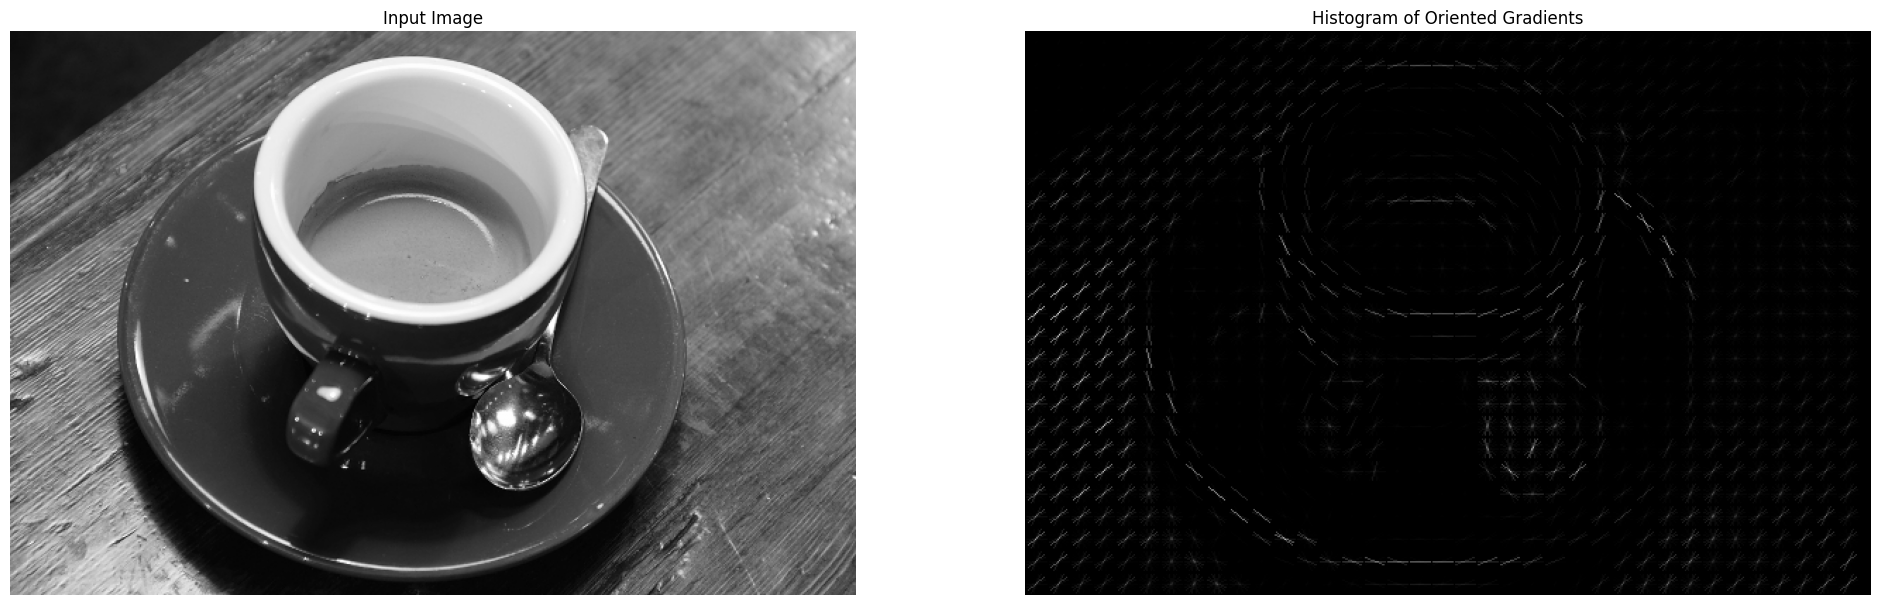

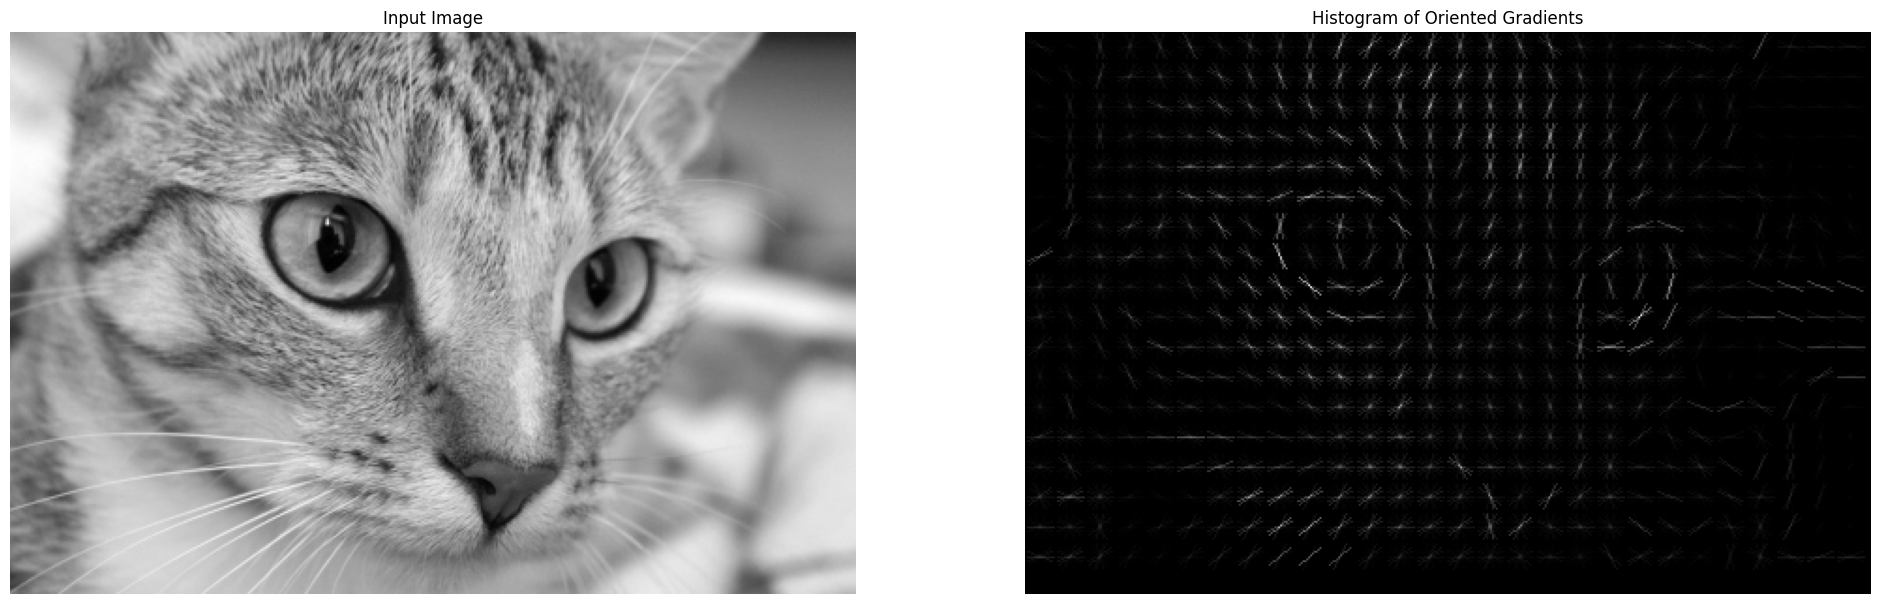

In [ ]:
for image_gray in images_gray:

    # TODO: Apply skimage.feature.hog to each gray image with
    # 9 orientations, 16x16 pixels per cell, 2x2 cells per block, set visualize to True
    fd, hog_image = hog( # fd: ndarray HOG descriptor for the image.
        image_gray,
        orientations=9,
        pixels_per_cell=(16,16),
        cells_per_block=(2,2),
        visualize=True
    )

    # TODO: Create a figure of size 24 x 12 with 2 subplots
    fig, plts = plt.subplots(1, 2, figsize=(24, 12))

    # TODO: Visualize input image using gray cmap
    # Set title to be Input image
    plts[0].imshow(image_gray, cmap='gray')
    plts[0].set_title('Input Image')
    config_plot(plts)

    # TODO: Visualize HOG using gray cmap
    # Note: normalize HOG image by its max and set vmin to 0 and vmax to 1
    # Set title to be Histogram of Oriented Gradients
    # conceptual note: why vmin/vmax? because we want to fix contrast scale across all images for visual comparison
    plts[1].imshow(hog_normalize(hog_image), cmap='gray', vmin=0, vmax=1)
    plts[1].set_title('Histogram of Oriented Gradients')
    config_plot(plts)


SIFT feature matching

In [37]:
def choose_random_matches(COUNT, matches):
  num_to_show = min(COUNT, len(matches))
  if num_to_show > 0:
      rng = np.random.default_rng()   # reproducible random generator
      subset_idx = rng.choice(len(matches), size=num_to_show, replace=False)
      matches_subset = matches[subset_idx]
  else:
      matches_subset = matches
  return matches_subset

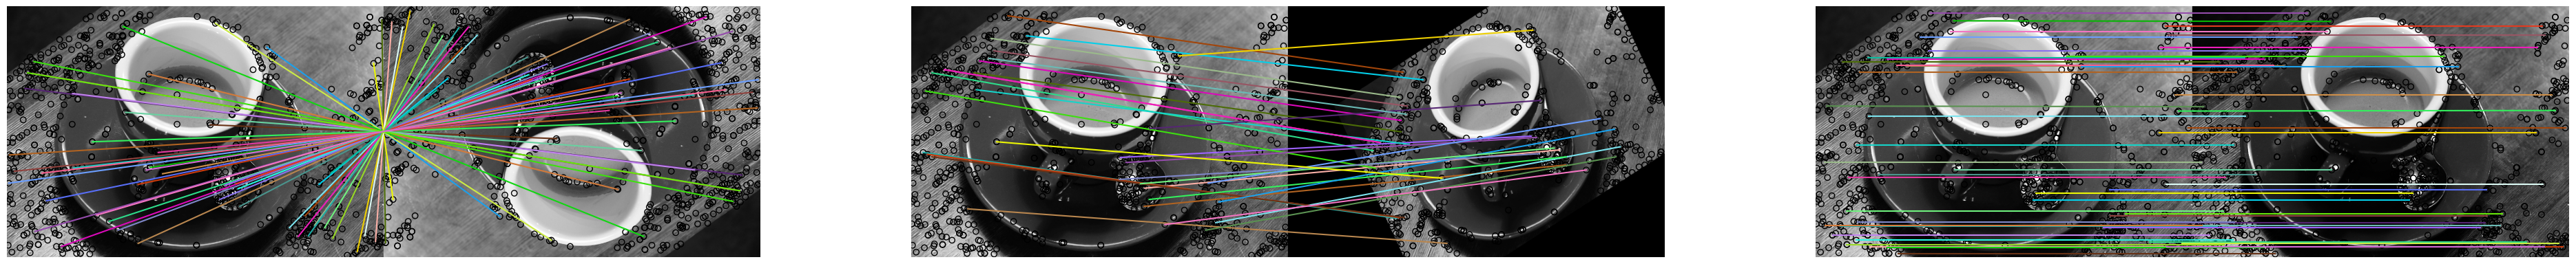

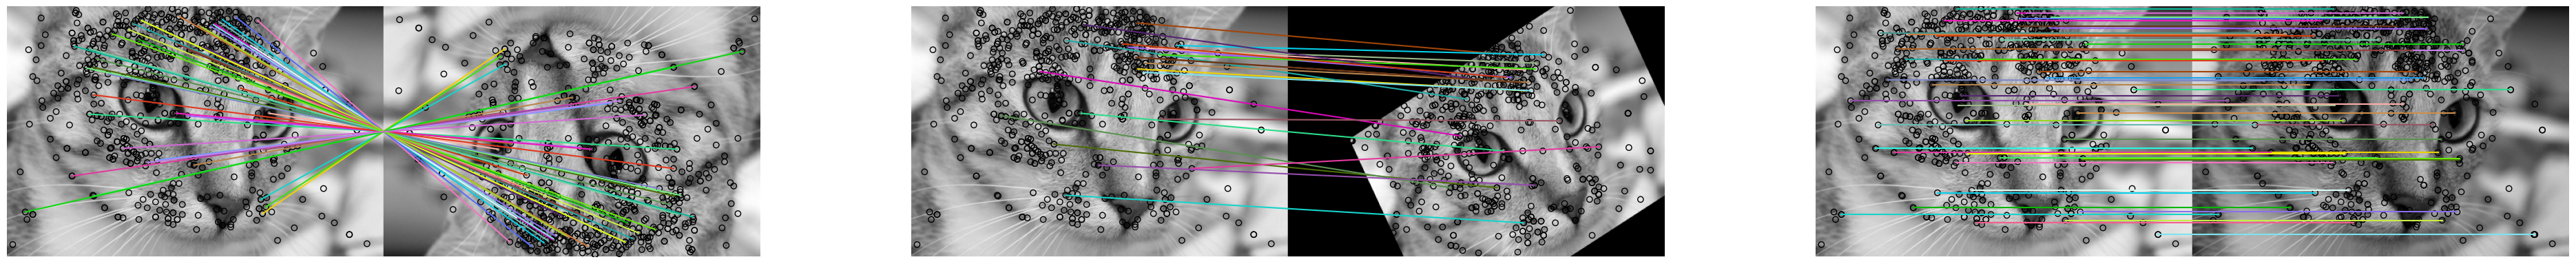

In [38]:
from skimage.feature import match_descriptors, SIFT, plot_matched_features
from skimage.transform import warp
import skimage.exposure

for image_gray in images_gray:

    # TODO: Rotate the image by 180 degrees using skimage
    image_rotated = skimage.transform.rotate(image_gray, 180)

    # TODO: Apply affine transformation with parameters:
    # scale=(1.3, 1.1), rotation=0.5 radians, translation=(0, -200)
    image_affine = skimage.transform.warp( image_gray, skimage.transform.AffineTransform( scale=(1.3, 1.1), rotation=0.5, translation=(0, -200)))

    # TODO: Reduce intensity of image by 40%
    image_darkened = skimage.exposure.adjust_gamma(image_gray, gamma=1.40)

    # TODO: Instantiate SIFT descriptor
    sift = SIFT()

    # TODO: Run SIFT on image, rotated image, affine transformed image, and darkened image
    sift.detect_and_extract(image_gray)
    keypoints1 = sift.keypoints.copy()
    descriptors1 = sift.descriptors.copy()

    # TODO: Run SIFT on rotated image
    sift.detect_and_extract(image_rotated)
    keypoints2 = sift.keypoints.copy()
    descriptors2 = sift.descriptors.copy()

    # TODO: Run SIFT on affine transformed image
    sift.detect_and_extract(image_affine)
    keypoints3 = sift.keypoints.copy()
    descriptors3 = sift.descriptors.copy()

    # TODO: Run SIFT on darkened image
    sift.detect_and_extract(image_darkened)
    keypoints4 = sift.keypoints.copy()
    descriptors4 = sift.descriptors.copy()

    # TODO: Match SIFT features between image and rotated image using Euclidean distance
    # using a max ratio of 0.2 between the closest two match before considering the match ambiguous
    # and cross check as True so only the the best matches from one image to the other and vice versa are returned
    matches12 = match_descriptors(descriptors1, descriptors2,
                                  metric='euclidean', max_ratio=0.2, cross_check=True)
    # TODO: Match SIFT features between image and affine transformed image using Euclidean distance
    # using a max ratio of 0.2 between the closest two match before considering the match ambiguous
    # and cross check as True so only the the best matches from one image to the other and vice versa are returned
    matches13 = match_descriptors(descriptors1, descriptors3,
                                  metric='euclidean', max_ratio=0.2, cross_check=True)

    # TODO: Match SIFT features between image and affine transformed image using Euclidean distance
    # using a max ratio of 0.2 between the closest two match before considering the match ambiguous
    # and cross check as True so only the the best matches from one image to the other and vice versa are returned
    # This was a duplicate line, removing it.


    # TODO: Match SIFT features between image and darkened image using Euclidean distance
    # using a max ratio of 0.2 between the closest two match before considering the match ambiguous
    # and cross check as True so only the the best matches from one image to the other and vice versa are returned
    matches14 = match_descriptors(descriptors1, descriptors4,
                                  metric='euclidean', max_ratio=0.2, cross_check=True)

    # Create visualization
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(48, 24))
    plt.gray()

    # TODO: Visualize the 50 random matches between image and rotated image
    plot_matched_features(image_gray, image_rotated,
                          keypoints0=keypoints1, keypoints1=keypoints2,
                          matches=choose_random_matches(50, matches12), ax=ax[0])
    ax[0].axis('off')

    # TODO: Visualize all matches between image and affine transformed image
    plot_matched_features(image_gray, image_affine,
                          keypoints0=keypoints1, keypoints1=keypoints3,
                          matches=matches13, ax=ax[1])
    ax[1].axis('off')

    # TODO: Visualize the 50 random matches between image and darkened image
    plot_matched_features(
      image_gray,
      image_darkened,
      keypoints0=keypoints1,
      keypoints1=keypoints4,
      matches=choose_random_matches(50, matches14),
      ax=ax[2],
    )
    ax[2].axis('off')

plt.show()